<a href="https://colab.research.google.com/github/alessandraalpino/airbnb-seattle/blob/main/Udacity_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Business Understanding

These were the questions we decided to explore in our dataset:

1. Which host's characteristics most affect reviews?
2. Which host's characteristics most affect prices?
3. How do the different accommodation's characteristics relate to price?

# Data Understanding

Here we used a dataset found in [Kaggle](https://www.kaggle.com/datasets/airbnb/seattle?resource=download&select=listings.csv) about Airbnbs in Seattle to answer the 3 questions. The dataset have 3818 listings of airbnbs and 92 columns about it's characteristics, such as: reviews, price, number of bedrooms.

# Data Preparation

In [122]:
import pandas as pd
import numpy as np 
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats
import plotly.graph_objects as go


In [123]:
df_listings = pd.read_csv('/content/listings.csv')

In [151]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

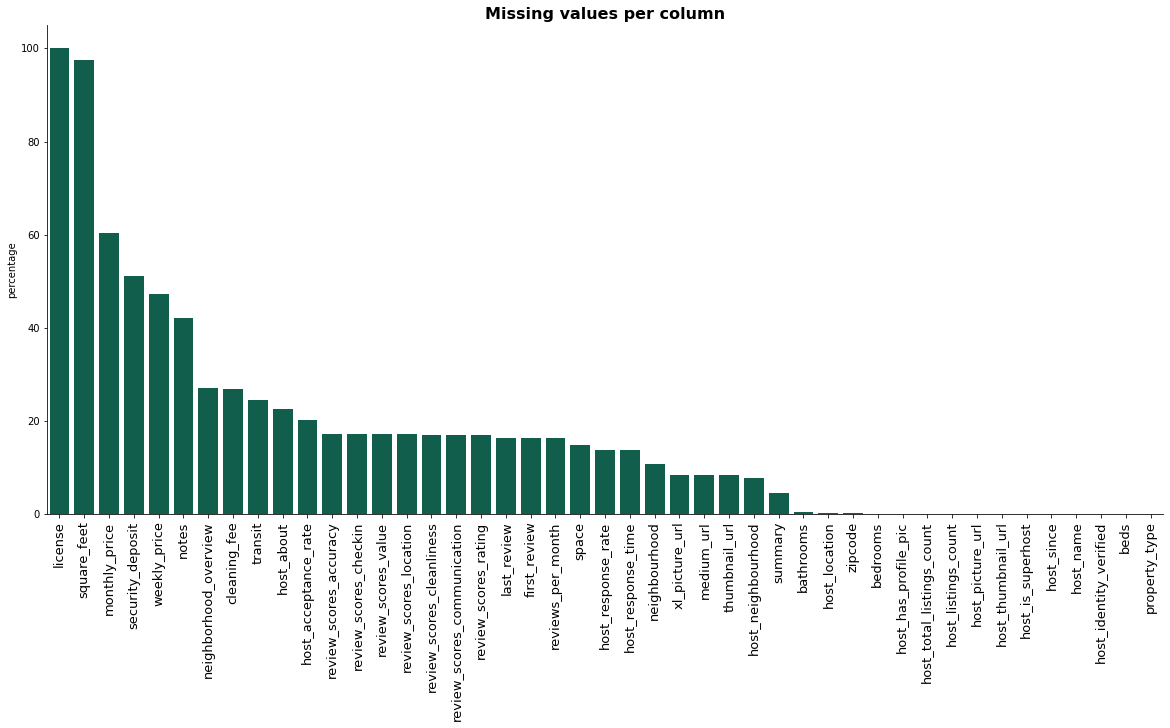

In [186]:
#create a data frime with the percentage of missing values for each column
df_listings_nans = pd.DataFrame(df_listings.isna().mean()*100,
                                columns=['percentage'])

#filter columns which have missing values
columns_with_nan = df_listings_nans.loc[df_listings_nans['percentage'] > 0]

#plot the results
plt.figure(figsize=(20,9))
plot_order = columns_with_nan.sort_values(by='percentage', ascending=False).index.values

sns.barplot(x=columns_with_nan.index,
            y=columns_with_nan['percentage'],
            order=plot_order,
            color='#036B52')
sns.despine()
plt.xticks(fontsize=13,rotation=90)
plt.title('Missing values per column', size=16, fontweight='bold')
plt.show()

**Cleaning the data**

In [126]:
# select columns about the host
host_cols = [col for col in df_listings.columns if 'host' in col]

In [157]:
# filter df with host's columns
host_df = df_listings[host_cols]

In [158]:
# get columns about review
host_df = host_df.merge(df_listings[['host_id','number_of_reviews','review_scores_rating','price','accommodates', 'bathrooms', 'bedrooms', 'beds']],
                        on='host_id',
                        how='inner')

In [159]:
host_df.tail()

,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,...,number_of_reviews,review_scores_rating,price,accommodates,bathrooms,bedrooms,beds,property_type,room_type,amenities
16323,11847918,https://www.airbnb.com/users/show/11847918,Ryan,2014-02-01,"Seattle, Washington, United States",NaN,within a few hours,100%,100%,f,...,2,100.0,$65.00,3,1.0,1.0,1.0,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A..."
16324,46566046,https://www.airbnb.com/users/show/46566046,Glen,2015-10-14,"Seattle, Washington, United States",I am a 58 year old male that is married to Mag...,within an hour,100%,100%,f,...,2,100.0,$79.00,4,1.0,1.0,2.0,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."
16325,52791370,https://www.airbnb.com/users/show/52791370,Virginia,2015-12-30,US,NaN,NaN,NaN,NaN,f,...,0,NaN,$93.00,2,1.0,1.0,1.0,House,Entire home/apt,"{""Cable TV"",""Wireless Internet"",Kitchen,""Free ..."
16326,25522052,https://www.airbnb.com/users/show/25522052,Karen,2015-01-03,"Tacoma, Washington, United States",NaN,within an hour,100%,NaN,f,...,0,NaN,$99.00,2,1.0,0.0,1.0,Condominium,Entire home/apt,"{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
16327,14703116,https://www.airbnb.com/users/show/14703116,Gil,2014-04-25,"Seattle, Washington, United States",NaN,within a day,100%,NaN,f,...,0,NaN,$87.00,3,1.5,2.0,1.0,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki..."


We'll delete columns that don't give us any useful data, such as: host_url, host_name, host_thumbnail_url, host_picture_url.

Theare are three columns with the same values: host_listings_count, host_total_listings_count and calculated_host_listings_count, so we'll keep just one of them. 

In [160]:
#delete useless columns
host_df = host_df.drop(columns=['host_url','host_name','host_thumbnail_url','host_picture_url','host_listings_count','calculated_host_listings_count'])

In [161]:
#clean columns with symbols
host_df['host_response_rate_clean'] = host_df['host_response_rate'].str.replace('%','').astype(float)/100
host_df['host_acceptance_rate_clean'] = host_df['host_acceptance_rate'].str.replace('%','').astype(float)/100
host_df['price_clean'] = host_df['price'].str.replace('$','').str.replace(',','').astype(float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



In [162]:
#check values of a column 
host_df['host_is_superhost'].unique()

array(['f', 't', nan], dtype=object)

In [163]:
host_df['host_has_profile_pic'].unique()

array(['t', 'f', nan], dtype=object)

In [164]:
host_df['host_identity_verified'].unique()

array(['t', 'f', nan], dtype=object)

In [165]:
host_df['host_response_time'].unique()

array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

In [166]:
#change strings to numeric 
host_df['host_response_time_clean'] = host_df['host_response_time'].map({'within an hour':1,
                                                                         'within a few hours':4,
                                                                         'within a day':24,
                                                                         'a few days or more':48})

**Creating new features**

In [137]:
# Amount of words in host_about
host_df['host_about_word_count'] = host_df['host_about'].str.split().str.len()

In [138]:
#create a columns with today's date
host_df['today_date'] = '2022-07-18'

#change types: object to datetime
host_df['host_since'] = pd.to_datetime(host_df['host_since'])
host_df['today_date'] = pd.to_datetime(host_df['today_date'])

#calculate date difference
host_df['days_as_host'] = (host_df['today_date'] - host_df['host_since']).dt.days

**Useful functions**

In [180]:
#plot heatmap without correlations that pvalue < 0.05
def plot_heatmap(rho, pval):

  mask = np.zeros_like(rho, dtype = np.bool) 
  mask = np.invert(np.tril(pval<0.05))
  mask[np.triu_indices_from(mask)] = True
  corr=rho.mask(mask)

  color = [[0.00, '#ffffff'],
          [0.25, '#e1e5eb'],
          [0.50, '#2fc18c'],
          [0.75, '#036b52'],
          [1.00, '#036b52']]

  data = go.Heatmap(
      x=corr.columns,
      y=corr.columns,
      z=corr.values.tolist(),
      colorscale=color,
      xgap=1, ygap=1
  )

  layout = go.Layout(title='Heatmap',
                    title_x=0.5,
                    height=800,
                    width=800,
                    xaxis_showgrid=False,
                    yaxis_showgrid=False,
                    yaxis_autorange='reversed',
                    xaxis_tickangle=90)

  fig = go.Figure(data=data, 
                  layout=layout)

  fig.show()

In [140]:
def test_statistical(df,col_group,col_analysis):

  #creating groups
  group_false = df.loc[df[col_group] == 'f'][col_analysis].dropna()
  group_true = df.loc[df[col_group] == 't'][col_analysis].dropna()

  #plot
  sns.kdeplot(group_false, color='#444955')
  sns.kdeplot(group_true, color='#036B52')
  sns.despine()
  plt.show()

  #statistical test
  levene = stats.levene(group_false,group_true)[1]
  if (stats.shapiro(group_false)[1] > 0.05) & (stats.shapiro(group_true)[1] > 0.05) & (levene > 0.05):
    measure = 'means'
    test = 'T-Test'
    pvalor = stats.ttest_ind(group_false,group_true)[1]

  else:
    pvalor = stats.mannwhitneyu(group_false,group_true)[1]
    measure = 'medians'
    test = 'Mann-Whitney U Test'


  if pvalor < 0.05:
    print(f"The group's {measure} are different according to {test} with a pvalue of {pvalor}. \n")

  else:
    print(f"The group's {measure} are equal according to {test} with a pvalue of {pvalor}. \n")

#Analysis

##**1. Which host's characteristics most affect reviews?**

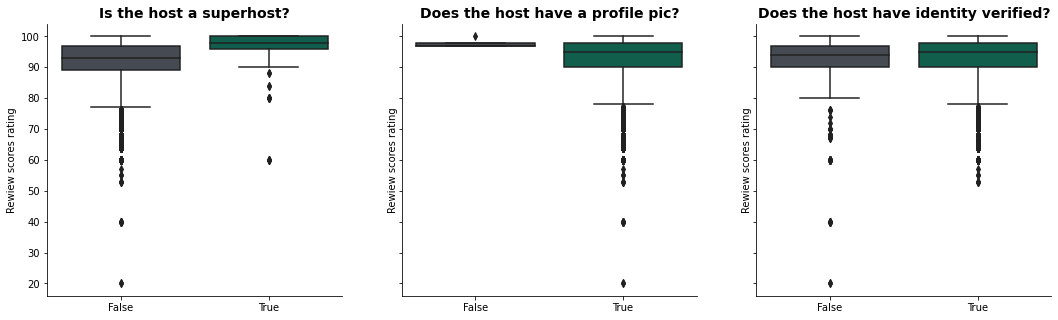

In [142]:
palette=['#444955','#036B52']

f, (ax1,ax2,ax3) = plt.subplots(ncols=3, 
                                figsize = (18,5),
                                sharey=True)

sns.boxplot(x='host_is_superhost',
            y='review_scores_rating',  
            data=host_df, 
            ax=ax1,
            palette=palette,
            order=['f','t'])
ax1.set_title('Is the host a superhost?', 
              size=14, fontweight=
              'bold')
ax1.set_xlabel('')
ax1.set_ylabel('Rewiew scores rating')
ax1.set_xticklabels(['False','True'])

sns.boxplot(x='host_has_profile_pic',
            y='review_scores_rating',  
            data=host_df, 
            ax=ax2,
            palette=palette,
            order=['f','t'])
ax2.set_title('Does the host has a profile pic?', 
              size=14, 
              fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Rewiew scores rating')
ax2.set_xticklabels(['False','True'])

sns.boxplot(x='host_identity_verified',
            y='review_scores_rating',  
            data=host_df, 
            ax=ax3,
            palette=palette,
            order=['f','t'])
ax3.set_title('Does the host has identity verified?', 
              size=14, 
              fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Rewiew scores rating')
ax3.set_xticklabels(['False','True'])


sns.despine()
plt.show()

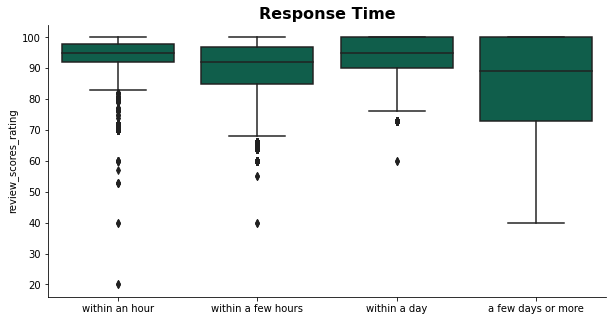

In [153]:
plt.figure(figsize=(10,5))
sns.boxplot(data=host_df,
            x='host_response_time',
            y='review_scores_rating',
            color='#036B52',
            order=['within an hour','within a few hours','within a day','a few days or more'])

plt.title('Response Time', 
          size=16, 
          fontweight='bold')
sns.despine()
plt.xlabel('')
plt.show()

According to airbnb, the superhost designation is a sign that the host has gotten consistently good reviews over at least a year of hosting. So, we confirmed with the plot that indeed superhosts have a higher median of reviews. 

We also found that having a profile picture and the identity verified don't seem aspects that affect the reviews.

On the other hand, when we look to response time hosts that take "a few days of more" to answer have more dispersed reviews. 25% of the reviews are between 40 and 70 for this group, while hosts that answers guests within a day os less have 100% of reviews (ignoring outliers) above 70. 

## **2. Which host's characteristics most affect price?**

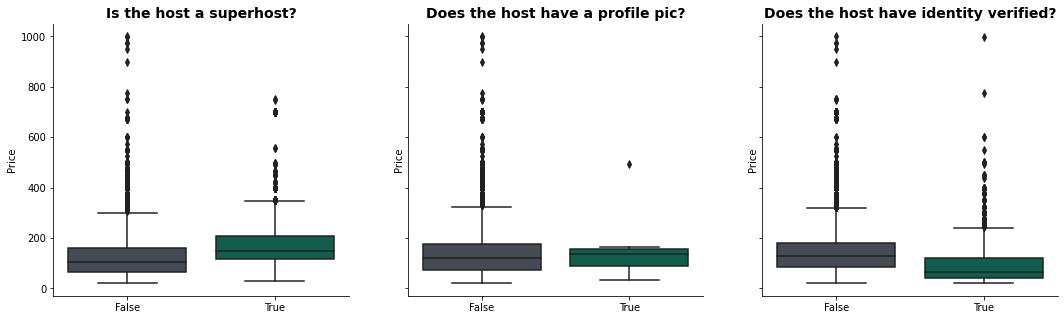

In [155]:
palette=['#444955','#036B52']

f, (ax1,ax2,ax3) = plt.subplots(ncols=3, 
                                figsize = (18,5),
                                sharey=True)

sns.boxplot(x='host_is_superhost',
            y='price_clean',  
            data=host_df, 
            ax=ax1,
            palette=palette)
ax1.set_title('Is the host a superhost?', 
              size=14, fontweight=
              'bold')
ax1.set_xlabel('')
ax1.set_ylabel('Price')
ax1.set_xticklabels(['False','True'])

sns.boxplot(x='host_has_profile_pic',
            y='price_clean',  
            data=host_df, 
            ax=ax2,
            palette=palette)
ax2.set_title('Does the host have a profile pic?', 
              size=14, 
              fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Price')
ax2.set_xticklabels(['False','True'])

sns.boxplot(x='host_identity_verified',
            y='price_clean',  
            data=host_df, 
            ax=ax3,
            palette=palette)
ax3.set_title('Does the host have identity verified?', 
              size=14, 
              fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Price')
ax3.set_xticklabels(['False','True'])


sns.despine()
plt.show()

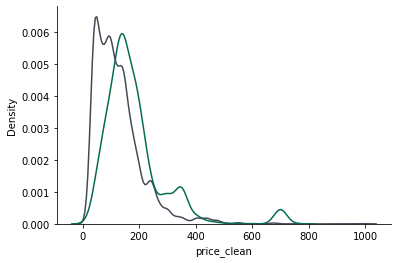

The group's medians are different according to Mann-Whitney U Test with a pvalue of 1.8018422511279783e-269. 



/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1760: UserWarning:

p-value may not be accurate for N > 5000.



In [145]:
test_statistical(host_df,'host_is_superhost','price_clean')

It looks like superhosts tend to charge more their listings.

In [147]:
select_cols = host_df[['host_total_listings_count','number_of_reviews','review_scores_rating','host_about_word_count','host_response_rate_clean','host_acceptance_rate_clean',
                    'host_response_time_clean','days_as_host','price_clean']]
rho = select_cols.corr()
pval = select_cols.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
plot_heatmap(rho, pval)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning:

An input array is constant; the correlation coefficient is not defined.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



We didn't find strong correlations.

## **3.How do the different accommodation's characteristics relate to price?**

In [181]:
select_cols = host_df[['review_scores_rating','price_clean','accommodates', 'bathrooms', 'bedrooms', 'beds']]
rho = select_cols.corr()
pval = select_cols.corr(method=lambda x, y: stats.pearsonr(x, y)[1]) - np.eye(*rho.shape)
plot_heatmap(rho, pval)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



We found strong correlations between price and accommodates, bedrooms, beds.

The strongest is with accomodates. Listings that accommodates more people tend to have higher prices.

There are some strong correlations between accommodates and bedrooms,beds, baths. However we should expect that listings that accomodates more people wil have more of those.

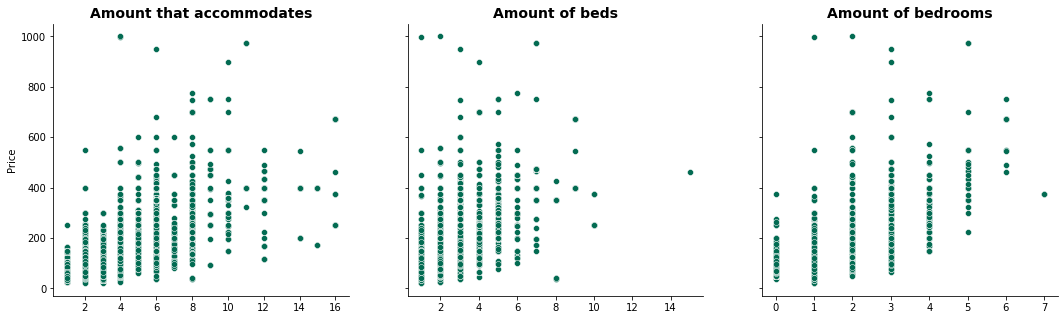

In [150]:
f, (ax1,ax2,ax3) = plt.subplots(ncols=3, 
                                figsize = (18,5),
                                sharey=True)

sns.scatterplot(x='accommodates',
                y='price_clean',  
                data=host_df, 
                ax=ax1,
                color='#036B52')
ax1.set_title('Amount that accommodates', 
              size=14, fontweight=
              'bold')
ax1.set_xlabel('')
ax1.set_ylabel('Price')

sns.scatterplot(x='beds',
                y='price_clean',  
                data=host_df, 
                ax=ax2,
                color='#036B52')
ax2.set_title('Amount of beds', 
              size=14, 
              fontweight='bold')
ax2.set_xlabel('')
ax2.set_ylabel('Price')

sns.scatterplot(x='bedrooms',
                y='price_clean',  
                data=host_df, 
                ax=ax3,
                color='#036B52')
ax3.set_title('Amount of bedrooms', 
              size=14, 
              fontweight='bold')
ax3.set_xlabel('')
ax3.set_ylabel('Price')


sns.despine()
plt.show()

# Results

Suggestions to people who wants to boost their listings on Airbnb or start hosting: 

1. Try to answer guests within 1 day or less.
2. Be a superhost.
3. Be aware that price is related to basic characteristics of the place, such as number of people it accommodates.